In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy import misc
from skimage import filters
from skimage.measure import shannon_entropy
import warnings
warnings.filterwarnings("ignore")

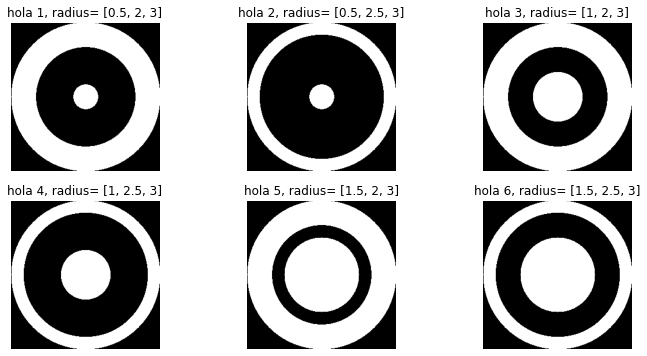

In [290]:
cen = 128
def mask(r):
    y, x = np.ogrid[0:256, 0:256]
    mask = (x-cen)**2+(y-cen)**2 <= r**2
    return mask
def kernel(mask):
    kernel = np.zeros((256, 256))
    kernel[mask] = 1
    return kernel
def hola_filter_gen(r):
    '''
    大問題 scale 到底怎麼處理捏 @@?
    '''
#     rate = 128/(r[0]+r[1]+r[2])
    rate = 128 / r[2]
    radius = np.dot(rate,(r[0], r[1], r[2]))
#     print(radius)
    hola_filter = kernel(mask(radius[2]))-kernel(mask(radius[1]))+kernel(mask(radius[0]))
#     f, (ax0,ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=4, figsize=(12,6))
#     ax0.imshow(kernel(mask(radius[2])),'gray')
#     ax0.set_title(f'radius={r[2]}')
#     ax1.imshow(kernel(mask(radius[1])),'gray')
#     ax1.set_title(f'radius={r[1]}')
#     ax2.imshow(kernel(mask(radius[0])),'gray')
#     ax2.set_title(f'radius={r[0]}')
#     ax3.imshow(hola_filter,'gray')
#     ax3.set_title(f'hola filter {r}')
    return hola_filter

r = [[0.5, 2, 3],[0.5, 2.5, 3],[1, 2, 3],[1, 2.5, 3],[1.5, 2, 3],[1.5, 2.5, 3]]
hola_set = []
for i in r:
    hola_set.append(hola_filter_gen(i))
    
plt.figure(figsize=(12, 6))
for i in range(len(hola_set)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(hola_set[i],'gray')
    plt.title(f'hola {i+1}, radius= {r[i]}')
    plt.axis("off")

def normalize(x): 
    ## f(.)
    return (x-np.min(x))/(np.max(x)-np.min(x))
def hola_thm(img,hola):
    hola_filter = hola_filter_gen(r[hola])
    ## fft
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    amplitude = np.log(np.abs(fshift))
    phase = np.angle(fshift)
    ## ifft
    A_prime = np.multiply(amplitude,hola_filter)
    ishift = np.fft.ifftshift(np.exp(A_prime+1j*phase))
    iimg = np.fft.ifft2(ishift)
    c = np.array(np.abs(iimg))**2
    c = normalize(c)
    ## Prewitt algorithm
    k = filters.prewitt(img) #input scale 0~255 or 0~1.0, output scale 0~1.0
    ## combine c & k
    c_prime = cv2.add(c, k)
    return c_prime
def entropy_2D(img):
    scale = 0.02; h, w = img.shape; size = np.int(scale*w) #做高斯模糊化
    img = cv2.GaussianBlur(img, (size,size), scale)
    img = normalize(img.astype(float))*255
    img = img.astype(np.uint8)
    score = shannon_entropy(img)
    return score

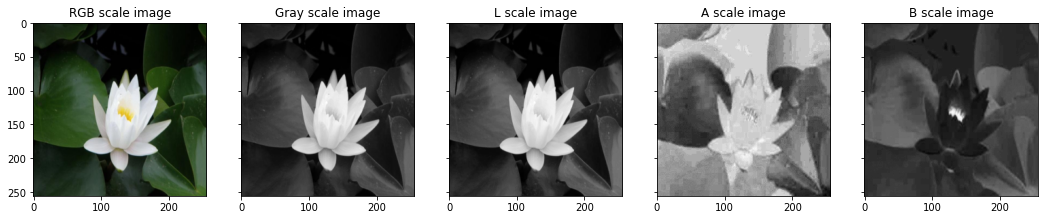

(<matplotlib.image.AxesImage at 0x15da41c9748>,
 Text(0.5, 1.0, 'enhanced saliency map c_prime'))

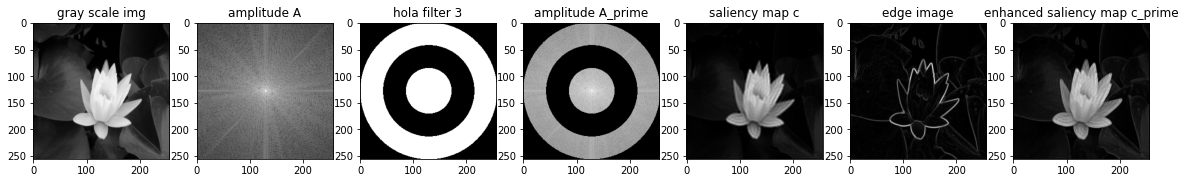

In [317]:
loc = r'C:\Users\User\chou_paper_data\for hola\Image_2.jpg'
# loc = r'C:\Users\User\chou_paper_data\MSRA10K_Imgs_GT\MSRA10K_Imgs_GT\Imgs\4340.jpg'
img = cv2.imread(loc)
img = cv2.resize(img,(256,256))
# img = cv2.resize(img, (128,128), interpolation=cv2.INTER_NEAREST)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
'''
Gray scale
'''
img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #paper上除了 gray, 還有 LAB 另外三個轉換
'''
LAB scale
'''
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img_l = img_lab[:,:,0]
img_a = img_lab[:,:,1]
img_b = img_lab[:,:,2]
f, (ax0 ,ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18, 6))
ax0.imshow(img_rgb), ax0.set_title('RGB scale image')
ax1.imshow(img_g,'gray'), ax1.set_title('Gray scale image')
ax2.imshow(img_l,'gray'), ax2.set_title('L scale image')
ax3.imshow(img_a,'gray'), ax3.set_title('A scale image')
ax4.imshow(img_b,'gray'), ax4.set_title('B scale image')
plt.show()

img = img_g
hola_f = hola_set[2]
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
amplitude = np.absolute(fshift)
phase = np.angle(fshift) #等價於 np.arctan
amplitude_p = np.multiply(amplitude,hola_f)

ishift = np.fft.ifftshift(amplitude_p*np.exp(1j*phase))
iimg = np.fft.ifft2(ishift)
iimg = np.absolute(iimg)**2
iimg = normalize(iimg)

f, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=7, figsize=(20,10))
ax0.imshow(img,'gray'), ax0.set_title('gray scale img')
ax1.imshow(np.log(amplitude),'gray'), ax1.set_title('amplitude A')
ax2.imshow(hola_f,'gray'), ax2.set_title(f'hola filter {2+1}')
ax3.imshow(np.log(amplitude_p+0.0001),'gray'), ax3.set_title('amplitude A_prime')
ax4.imshow(iimg,'gray'), ax4.set_title('saliency map c')
ax5.imshow(filters.prewitt(img),'gray'), ax5.set_title('edge image')
ax6.imshow(cv2.add(iimg,filters.prewitt(img)),'gray'), ax6.set_title('enhanced saliency map c_prime')

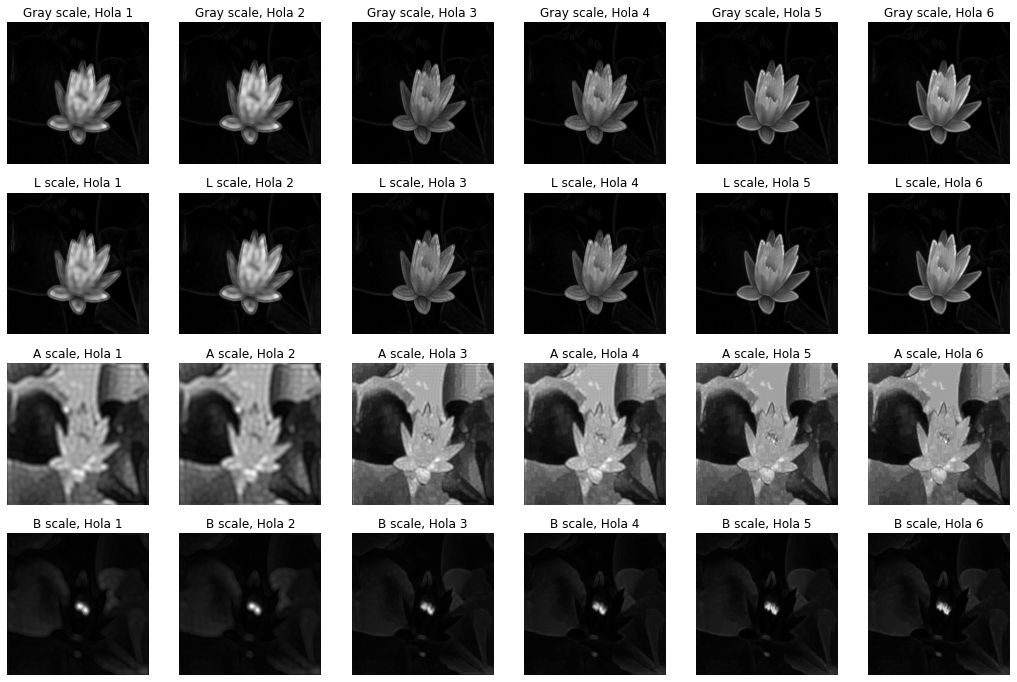

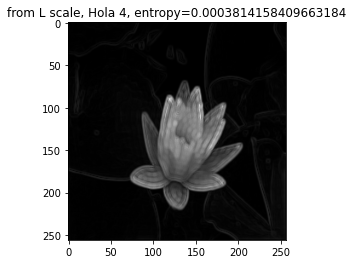

In [320]:
saliencymap = []; entropy = []; img_set = [img_g, img_l, img_a, img_b]
def matlab_style_gauss2D(shape,sigma):
    """ref:
    https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h
def entropy_2D(img):
    scale = 0.02; h, w = img.shape; sgm = scale*w
    p = normalize(img)
    z = p / np.sum(p)
    ker = matlab_style_gauss2D(shape=(w, w), sigma=w/4)
    ker = ker / np.max(ker)
    z = z*ker
    z = np.sum(z)
    p = signal.convolve2d(p, matlab_style_gauss2D(shape=(7, 7), sigma=sgm), boundary='symm', mode='same')
    p = normalize(p)*255
    p = img.astype(np.uint8)
    score = shannon_entropy(p) / z
    return score
def final_chose():
    for i in range(len(img_set)):
        for j in range(len(hola_set)):
            c1 = hola_thm(img_set[i], hola=j)
            c2 = hola_thm(c1, hola=j)
            saliencymap.append(c2)
            entropy.append(entropy_2D(c2))
    plt.figure(figsize=(18, 12))
    for i in range(len(saliencymap)):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(saliencymap[i],'gray')
        if i//6 == 0:
            plt.title(f'Gray scale, Hola {i % 6 +1}')
        elif i //6 ==1:
            plt.title(f'L scale, Hola {i % 6 +1}')
        elif i //6 ==2:
            plt.title(f'A scale, Hola {i % 6 +1}')
        elif i //6 ==3:
            plt.title(f'B scale, Hola {i % 6 +1}')
        plt.axis("off")
    plt.show()
    final = np.argmin(entropy)
    plt.imshow(saliencymap[final], 'gray')
    if final//6 == 0:
        plt.title(f'from Gray scale, Hola {final % 6 +1}, entropy={entropy[final]}')
    elif final//6 ==1:
        plt.title(f'from L scale, Hola {final % 6 +1}, entropy={entropy[final]}')
    elif final//6 ==2:
        plt.title(f'fromA scale, Hola {final % 6 +1}, entropy={entropy[final]}')
    elif final//6 ==3:
        plt.title(f'from B scale, Hola {final % 6 +1}, entropy={entropy[final]}')
    plt.show()
    
final_chose()

In [321]:
entropy

[0.007206511331368753,
 0.01016180618068192,
 0.000707755468907494,
 0.0013183507714108322,
 0.012778899601719192,
 0.012730740406860001,
 0.006387402079618245,
 0.008522250644140047,
 0.0007241148293394887,
 0.0003814158409663184,
 0.011491700781100081,
 0.0154374571162867,
 0.004851213689928763,
 0.0017926736333548714,
 0.001803114088599683,
 0.00536270521247612,
 0.005346269680822299,
 0.002867653661882451,
 0.00590702301349687,
 0.0018233993450268101,
 0.0023544775949801634,
 0.003376521786305296,
 0.013025735090282278,
 0.011751644193607459]